# Importing the libraries 

In [1]:
%pip install termcolor

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

In [3]:
import warnings

# Use the warnings filter context manager to ignore specific warnings
with warnings.catch_warnings():
    # Filter out Pandas warnings
    warnings.filterwarnings("ignore", category=FutureWarning)

##### Reading the data and basic understanding of data

In [4]:
df = pd.read_csv("loan.csv")
df.shape

/Users/geotech/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3526: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(39717, 111)

We have 111 columns in the beginning

# 1. Data Cleaning
### Step 1 - Drop Empty columns

In [5]:
empty_columns = df.columns[df.isna().sum() == len(df)].to_list()
df1 = df.drop(columns=empty_columns)
df1.shape

(39717, 57)

### Step 2 - Drop Single Valued Columns 

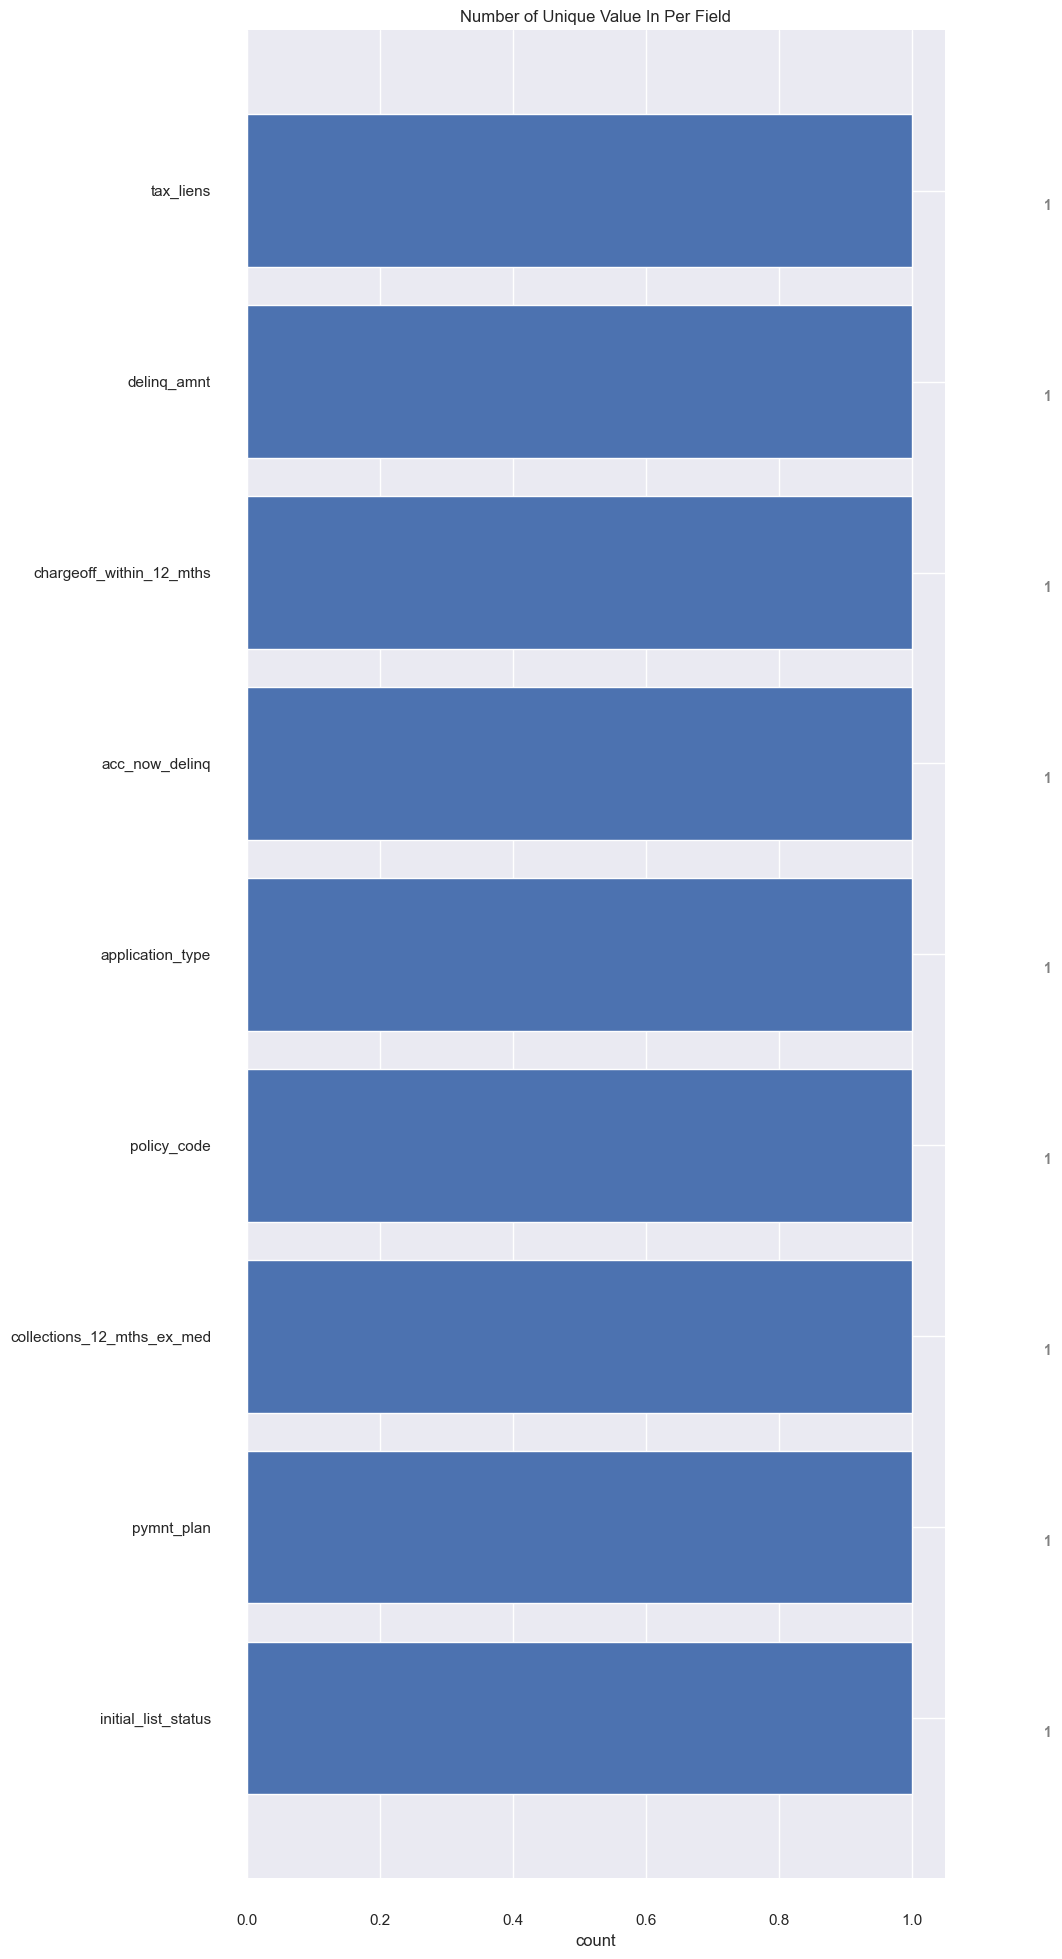

In [31]:
constant_df = df1.nunique().to_frame(name='unique_value')
constant_df = constant_df.reset_index()
constant_df = constant_df.rename(columns={'index': 'field'}).sort_values(by='unique_value', ascending=True)

# Filter just constant fields
constant_df = constant_df[constant_df['unique_value'] == 1]

# Figure Size
fig, ax = plt.subplots(figsize =(9, 24))
 
# Horizontal Bar Plot
ax.barh(constant_df["field"], constant_df["unique_value"])

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Set title
ax.set_title('Number of Unique Value In Per Field')
ax.set_xlabel('count')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 20)
ax.yaxis.set_tick_params(pad = 20)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 

plt.show()

In [7]:
single_valued_cols = df1.columns[df1.nunique() == 1].to_list()
df2 = df1.drop(columns=single_valued_cols)
df2.shape

(39717, 48)

### Step 3 - Drop Unique Field

In [8]:
unique = df.columns[df.nunique() == len(df2)].to_list()
df3 = df2.drop(columns=unique)
df3.shape

(39717, 45)

### Step 4 - Drop Fields which has high number of missing values

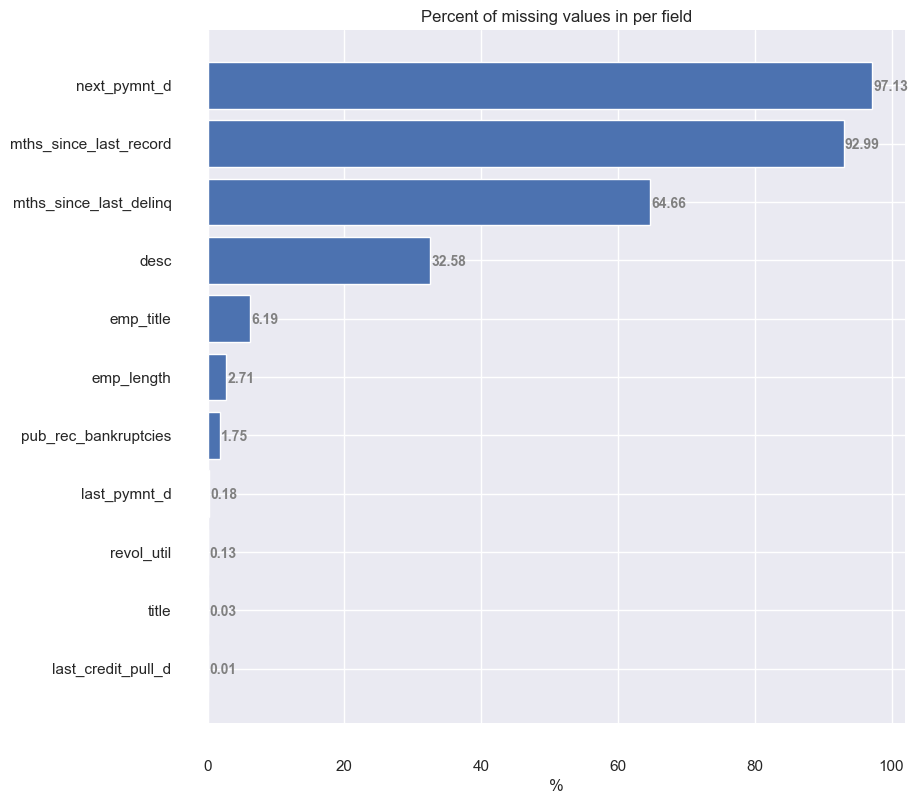

In [30]:
# We measure percentage missing value in per field and introduce a new dataframe to monitor
missing_df = df3.isnull().sum() * 100 / len(df)
missing_df.to_frame(name="percent_missing")

missing_df = missing_df.reset_index()
missing_df.columns = ['field', 'percent_missing']
missing_df = missing_df.sort_values(by="percent_missing", ascending=False)

# Filter high-percentage missing

missing_df = missing_df[missing_df['percent_missing'] > 0]
# Figure Size
fig, ax = plt.subplots(figsize =(9, 9))
 
# Horizontal Bar Plot
ax.barh(missing_df["field"], missing_df["percent_missing"])

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Set title
ax.set_title('Percent of missing values in per field')
ax.set_xlabel('%')


# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 20)
ax.yaxis.set_tick_params(pad = 20)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 

plt.show()

In [10]:
high_missing_fields = df3.columns[round(df3.isna().sum()*100/len(df2), 0) > 90]
df4 = df3.drop(columns=high_missing_fields)
df4.shape

(39717, 43)

In [11]:
high_missing_fields

Index(['mths_since_last_record', 'next_pymnt_d'], dtype='object')

- mths_since_last_record
- next_pymnt_d

Remove these 2 fields


### Step 5 - Drop Fields which has most of the numbers at 0 and remaning are outliers
- delinq_2yrs
- pub_rec
- out_prncp
- out_prncp_inv

remove 4 fields

In [12]:
dropping_fields = ['delinq_2yrs', 'pub_rec', 'out_prncp', 'out_prncp_inv']
df5 = df4.drop(columns=dropping_fields)
df5.shape

(39717, 39)

### Step 6 - Drop Unnecessary fields which wont help in analysis
- emp_title
- desc
- title
- zip_code
- mths_since_last_delinq
- total_pymnt
- total_pymnt_inv
- total_rec_int
- total_rec_late_fee
- recoveries
- collection_recovery_fee
- last_pymnt_d
- last_pymnt_amnt
- pub_rec_bankruptcies


remove above 14 fields

In [13]:
unnecessary_fields = ['emp_title', 'desc', 'title', 'zip_code', 'mths_since_last_delinq', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'pub_rec_bankruptcies']
df6 = df5.drop(columns=unnecessary_fields)
df6.shape

(39717, 25)

### Convert Datatypes of fields

In [14]:
def load_type_df(df: pd.DataFrame, filter_type: str = None) -> pd.DataFrame:
    default_type_df = df.dtypes.to_frame(name='default_type')
    default_type_df = default_type_df.reset_index()

    if filter_type:
        default_type_df = default_type_df[default_type_df['default_type'] == filter_type]

    return default_type_df.rename(columns={'index': 'field'})


def assert_datatypes(df: pd.DataFrame) -> pd.DataFrame:

    default_type_df = load_type_df(df)

    expected_type_df = pd.read_csv("expected_datatype.csv")
    types_df = pd.merge(default_type_df, expected_type_df, how='left', on='field')
    return types_df[types_df['default_type'] != types_df['expected_type']]


df6_dtypes = assert_datatypes(df6)
df6_dtypes

,field,default_type,expected_type
4,int_rate,object,float64
12,issue_d,object,datetime64[ns]
17,earliest_cr_line,object,datetime64[ns]
21,revol_util,object,float64
24,last_credit_pull_d,object,datetime64[ns]


#### Doubt : What is the use of filter_type in load_type_df function?

In [15]:
df7 = df6.copy()

df7['int_rate'] = df6['int_rate'].apply(lambda x: float(x[:-1]) if isinstance(x, str) else float(x))
df7['revol_util'] = df6['revol_util'].apply(lambda x: float(x[:-1]) if isinstance(x, str) else float(x))
df7['issue_d'] = df6['issue_d'].apply(lambda x: pd.to_datetime(x, format='%b-%y'))
df7['earliest_cr_line'] = df6['earliest_cr_line'].apply(lambda x: pd.to_datetime(x, format='%b-%y'))
df7['last_credit_pull_d'] = df6['last_credit_pull_d'].apply(lambda x: pd.to_datetime(x, format='%b-%y'))

In [16]:
df_final = df7.copy()
df_final['is_default'] = df7['loan_status'].apply(lambda x: 'YES' if x == 'Charged Off' else 'NO')
df_final.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,dti,earliest_cr_line,inq_last_6mths,open_acc,revol_bal,revol_util,total_acc,total_rec_prncp,last_credit_pull_d,is_default
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,...,27.65,1985-01-01,1,3,13648,83.7,9,5000.00,2016-05-01,NO
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,1.00,1999-04-01,5,3,1687,9.4,4,456.46,2013-09-01,YES
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,...,8.72,2001-11-01,2,2,2956,98.5,10,2400.00,2016-05-01,NO
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,...,20.00,1996-02-01,1,10,5598,21.0,37,10000.00,2016-04-01,NO
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,...,17.94,1996-01-01,0,15,27783,53.9,38,2475.94,2016-05-01,NO


# 2. Bucketizing the fields into Categorical and Numeric variables 

## Categorical Fields

### Unordered Categorical Variables
- term - 36 or 60 months
- grade - LC assigned loan grade
- sub_grade - it is sub-division of grade
- home_ownership - home ownership status RENT, OWN, MORTGAGE, OTHER.
- verification_status - Indicates if income was verified by LC, not verified, or if the income source was verified
- loan_status
- purpose
- addr_state

### Ordered Categorical Variables
- emp_length - Employment length in years
- inq_last_6mths - The number of inquiries in past 6 months


## Quantitative Fields
- loan_amnt
- funded_amnt
- funded_amnt_inv - This is almost same as 'funded_amnt' field
- int_rate
- installment
- annual_inc
- dti - I feel this is an important field. We have to look at the meaning of this field
- total_rec_prncp- Principal received to date- How to use this field in analysis?

- revol_bal
- revol_util - we need to check the correlation between 'revol_bal' and 'revol_util'. If both means the same then remove one.

- total_acc
- open_acc


## Date Fileds
- issue_d
- earliest_cr_line
- last_credit_pull_d - we should find is there any relation between these 3 data fields


# 3. Univariate Analysis 
---
## A. Unordered Categorical Variables/Fields

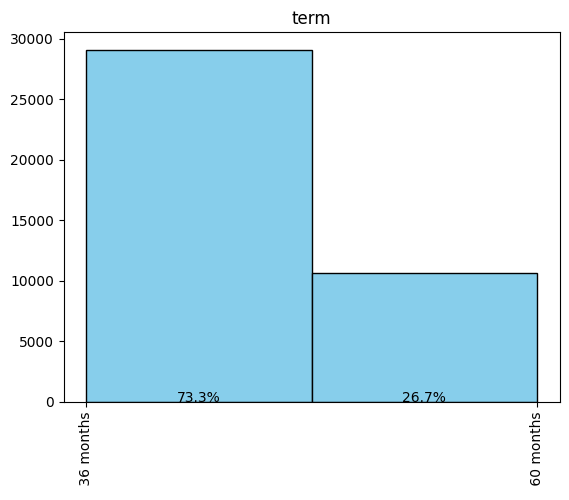

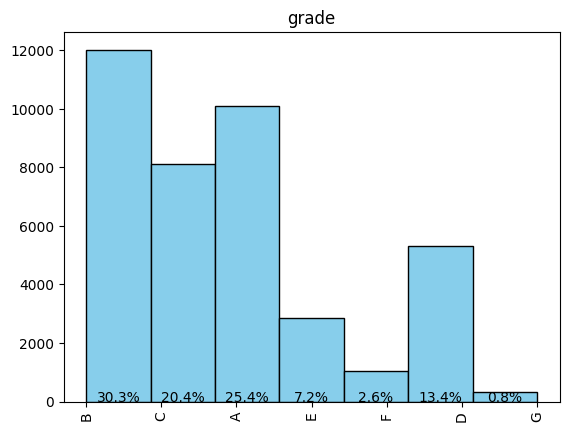

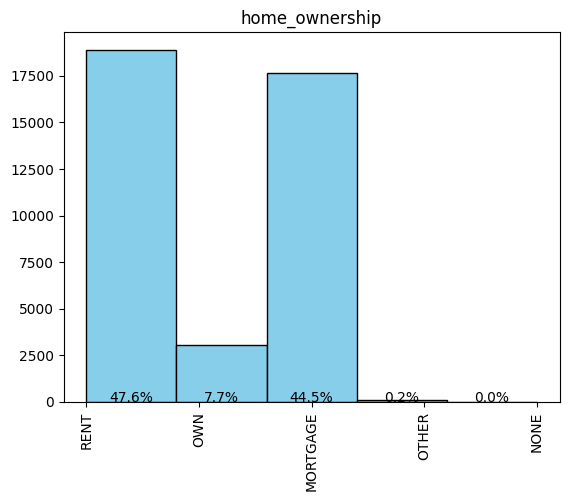

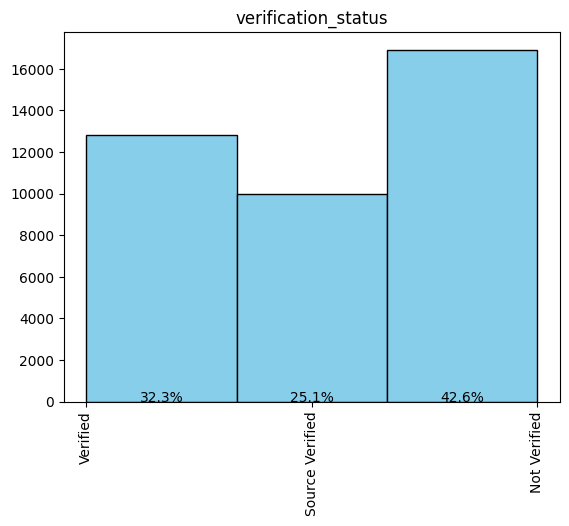

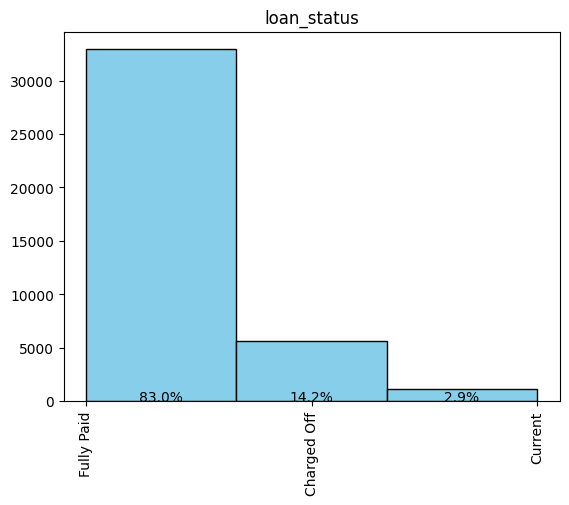

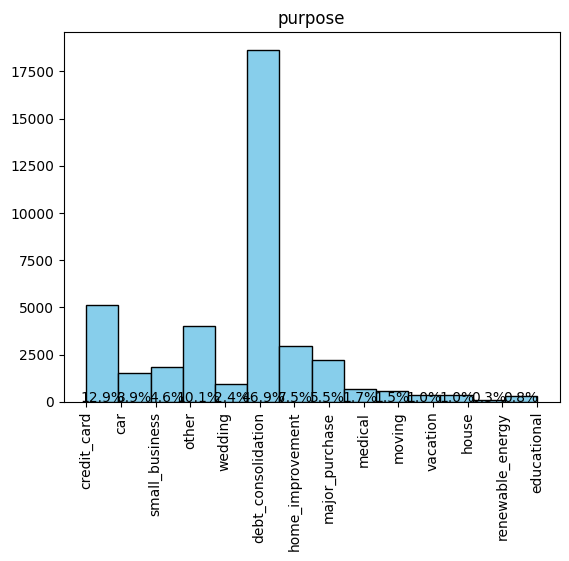

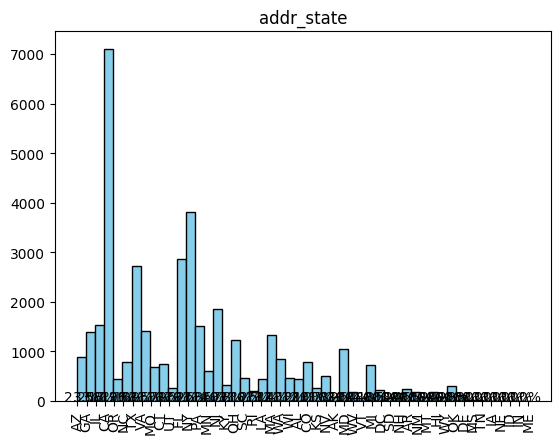

In [17]:
unordered_categorical = ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state']

for field in unordered_categorical:
    item_count = df_final[field].nunique()
    n, bins, patches = plt.hist(df_final[field], bins=item_count, color='skyblue', edgecolor='black')
    
    plt.title(field)
    plt.xticks(rotation = 90)
    
    # Calculate the percentage for each bin
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_counts = n.astype(int)  # Convert counts to integers

    # Annotate each bar with its percentage value
    for count, x in zip(bin_counts, bin_centers):
        percentage = f'{(count / len(df_final[field])) * 100:.1f}%'
        plt.annotate(percentage, (x, 0.02), ha='center')
    
    plt.show()

<span style="color:green">Inferences - Unordered Univariate Analysis :  </span>

- Term = Most of the borrowers (73%) apply for 36 months loan than 60 months loan(27%). Or company easily sanctions loan for 36 months period than 60 months  
- Grade = Most common loan grades are B(30%), A(25%) and C(20%)  
- home_ownership, purpose = Most of the borrowers dont have their own house. 92% borrowers either pay "Rent" or "Mortgage" their house. But only 1% borrowers''purpose' of the loan is 'house'. And 47% borrowers' purpose is 'debt_consolidation'. May be home loans are costlier.  
- verification_status = 42% of the borrowers' income is 'not verified' which is risky.  
- loan_status = Only 14% of the borrowers are 'Defaulters'  


## B. Ordered Categorical Variables

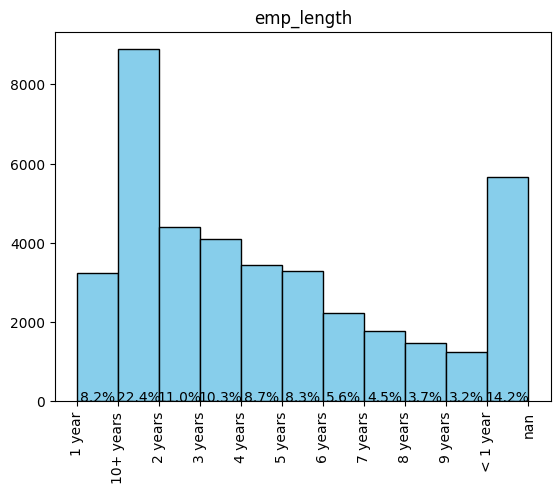

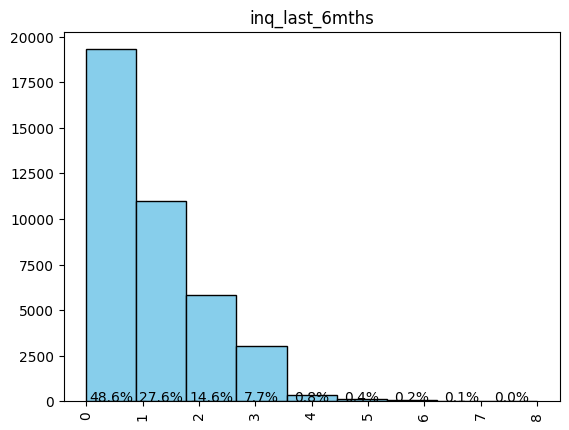

In [18]:
ordered_categorical = ['emp_length', 'inq_last_6mths']


for field in ordered_categorical:
    item_count = df_final[field].nunique()
    dataset = df_final[field].sort_values().astype(str).dropna()
    n, bins, patches = plt.hist(dataset, bins=item_count, color='skyblue', edgecolor='black')
    
    plt.title(field)
    plt.xticks(rotation = 90)
    
    # Calculate the percentage for each bin
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    bin_counts = n.astype(int)  # Convert counts to integers

    # Annotate each bar with its percentage value
    for count, x in zip(bin_counts, bin_centers):
        percentage = f'{(count / len(df_final[field])) * 100:.1f}%'
        plt.annotate(percentage, (x, 0.02), ha='center')
    
    plt.show()

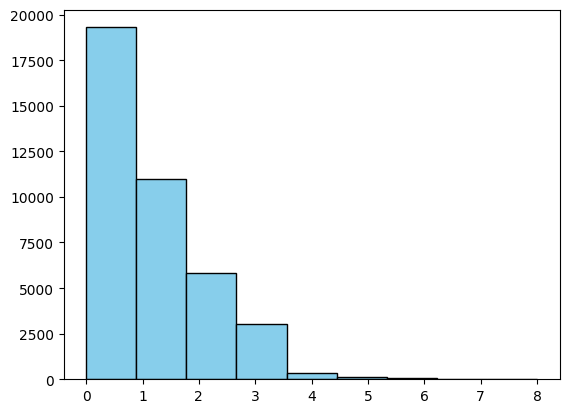

In [19]:
plt.hist(df_final['inq_last_6mths'], bins=item_count, color='skyblue', edgecolor='black')
plt.show()

<span style="color:green">Inferences - Ordered Univariate Analysis:  </span>
- emp_length = Almost equal distribution in each category. I am getting error in plotting histogram for this  
- inq_last_6mths = Very few inquiries are there in last 6 months. (i dont know whether this is inquiry from public side/customer side or from company side)

## C. Quantitative Variable Analysis
___

loan_amnt


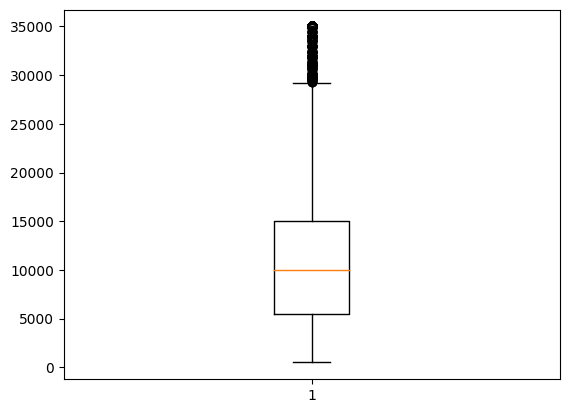

count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64
**************************************************
funded_amnt


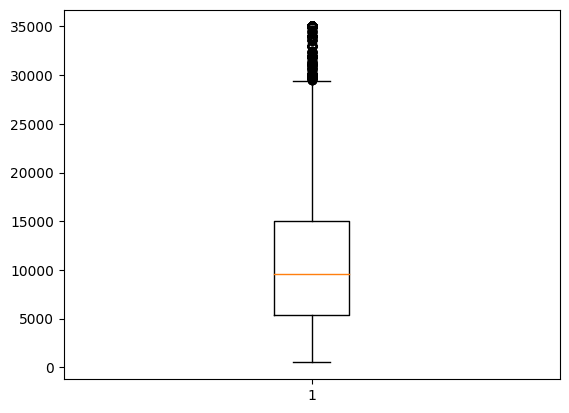

count    39717.000000
mean     10947.713196
std       7187.238670
min        500.000000
25%       5400.000000
50%       9600.000000
75%      15000.000000
max      35000.000000
Name: funded_amnt, dtype: float64
**************************************************
funded_amnt_inv


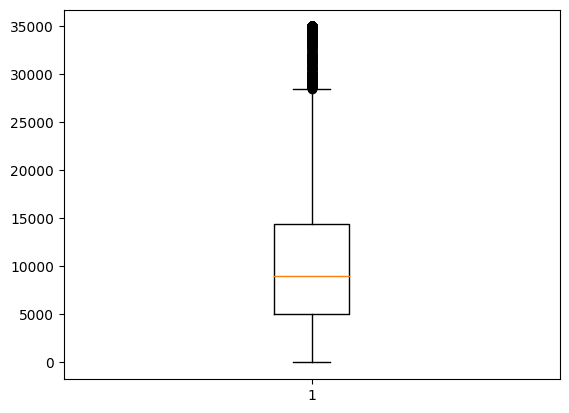

count    39717.000000
mean     10397.448868
std       7128.450439
min          0.000000
25%       5000.000000
50%       8975.000000
75%      14400.000000
max      35000.000000
Name: funded_amnt_inv, dtype: float64
**************************************************
int_rate


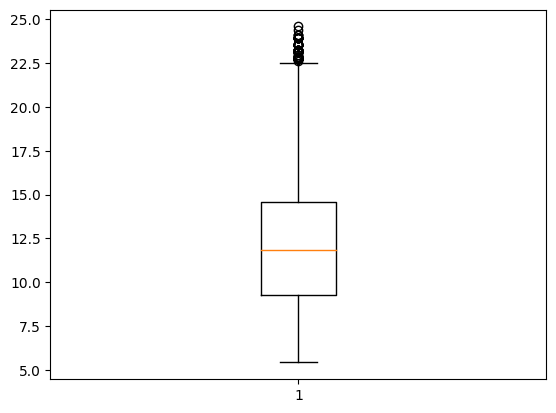

count    39717.000000
mean        12.021177
std          3.724825
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64
**************************************************
installment


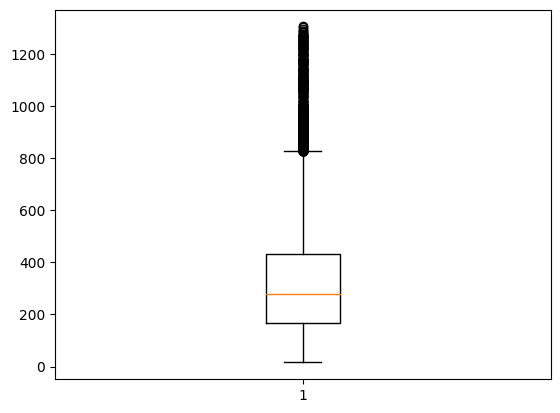

count    39717.000000
mean       324.561922
std        208.874874
min         15.690000
25%        167.020000
50%        280.220000
75%        430.780000
max       1305.190000
Name: installment, dtype: float64
**************************************************
annual_inc


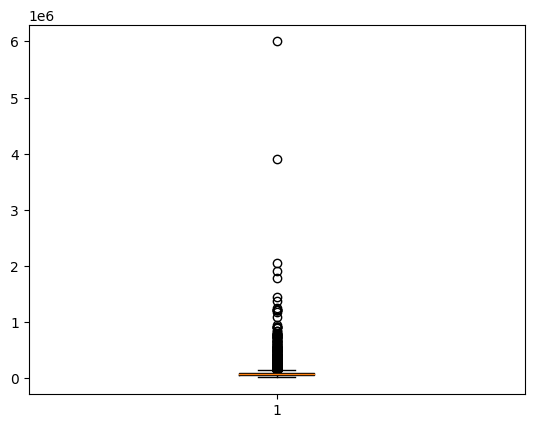

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
25%      4.040400e+04
50%      5.900000e+04
75%      8.230000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64
**************************************************
dti


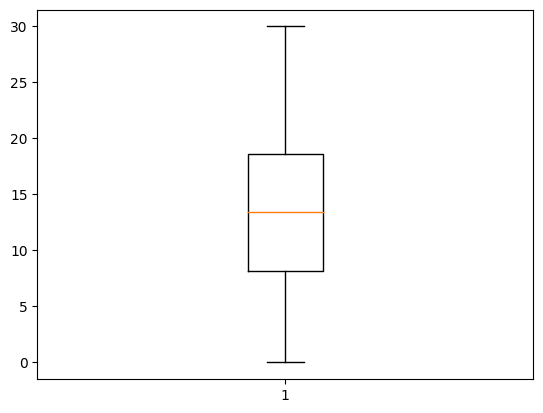

count    39717.000000
mean        13.315130
std          6.678594
min          0.000000
25%          8.170000
50%         13.400000
75%         18.600000
max         29.990000
Name: dti, dtype: float64
**************************************************
total_rec_prncp


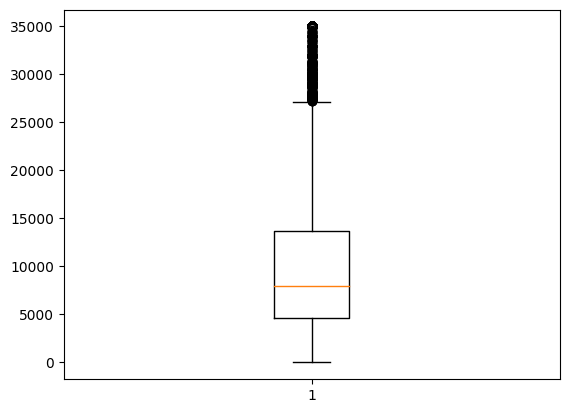

count    39717.000000
mean      9793.348813
std       7065.522127
min          0.000000
25%       4600.000000
50%       8000.000000
75%      13653.260000
max      35000.020000
Name: total_rec_prncp, dtype: float64
**************************************************
revol_bal


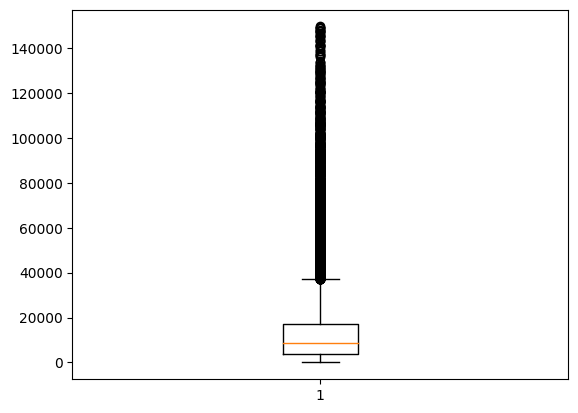

count     39717.000000
mean      13382.528086
std       15885.016641
min           0.000000
25%        3703.000000
50%        8850.000000
75%       17058.000000
max      149588.000000
Name: revol_bal, dtype: float64
**************************************************
revol_util


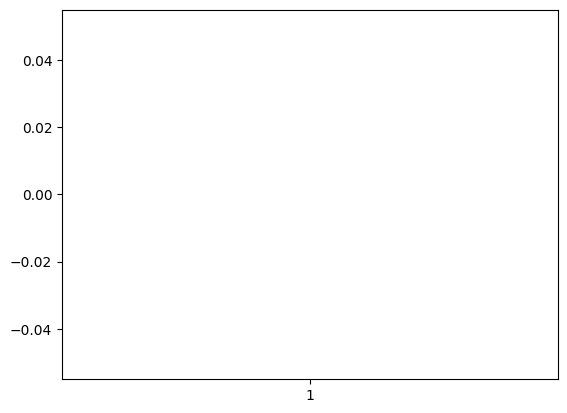

count    39667.000000
mean        48.832152
std         28.332634
min          0.000000
25%         25.400000
50%         49.300000
75%         72.400000
max         99.900000
Name: revol_util, dtype: float64
**************************************************
total_acc


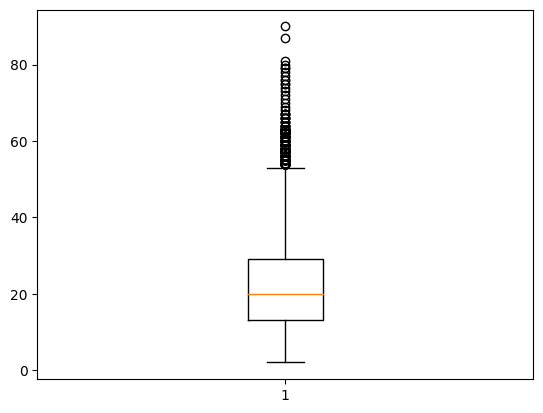

count    39717.000000
mean        22.088828
std         11.401709
min          2.000000
25%         13.000000
50%         20.000000
75%         29.000000
max         90.000000
Name: total_acc, dtype: float64
**************************************************
open_acc


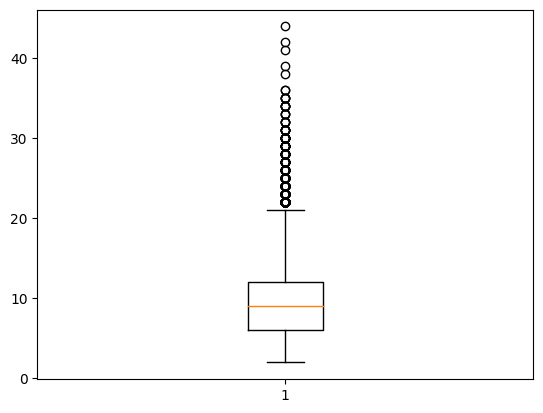

count    39717.000000
mean         9.294408
std          4.400282
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64
**************************************************


In [20]:
quantitative_fields = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'total_rec_prncp', 'revol_bal', 'revol_util', 'total_acc', 'open_acc']

for field in quantitative_fields:
    print(colored(field, 'red'))
    plt.boxplot(df_final[field])
    plt.show()
    print(df_final[field].describe())
    print("*" * 50)

# 4. Segmented Univariate Analysis
___

field =  loan_amnt 



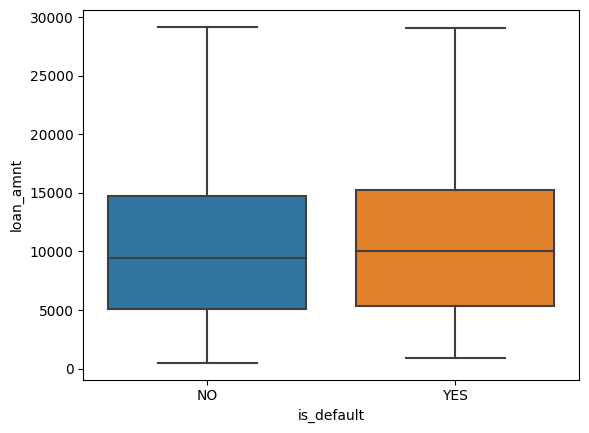

               loan_amnt                                             
                    mean  min    max <lambda_0> <lambda_1> <lambda_2>
is_default                                                           
NO          11073.372690  500  35000     5450.0     9800.0    15000.0
YES         12104.385108  900  35000     5600.0    10000.0    16500.0
--------------------------------------------------------------------------------
field =  funded_amnt 



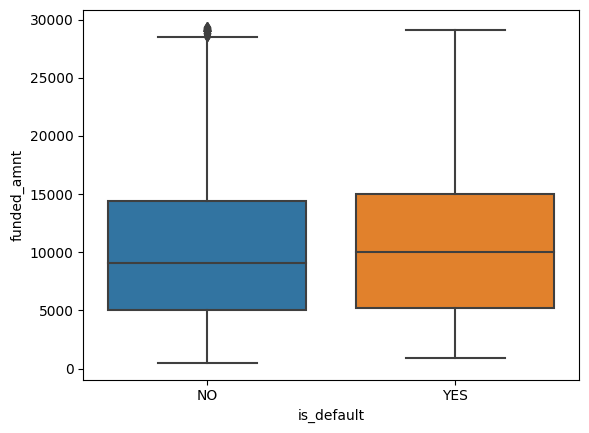

             funded_amnt                                             
                    mean  min    max <lambda_0> <lambda_1> <lambda_2>
is_default                                                           
NO          10814.724259  500  35000    5356.25     9600.0    15000.0
YES         11753.398792  900  35000    5575.00    10000.0    16000.0
--------------------------------------------------------------------------------
field =  funded_amnt_inv 



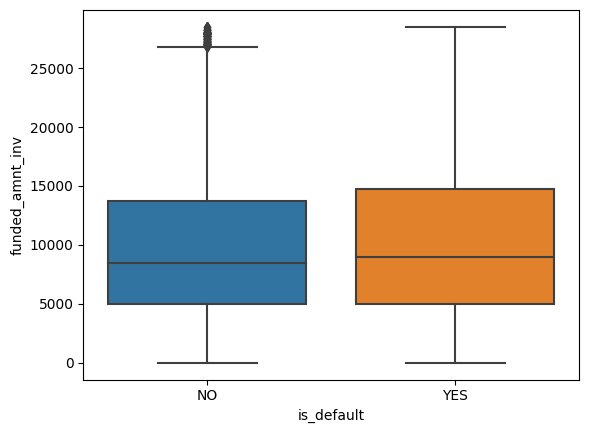

           funded_amnt_inv                                                 
                      mean  min      max <lambda_0>   <lambda_1> <lambda_2>
is_default                                                                 
NO            10320.352455  0.0  35000.0     5000.0  8900.000000    14100.0
YES           10864.521324  0.0  35000.0     5000.0  9401.209477    15000.0
--------------------------------------------------------------------------------
field =  int_rate 



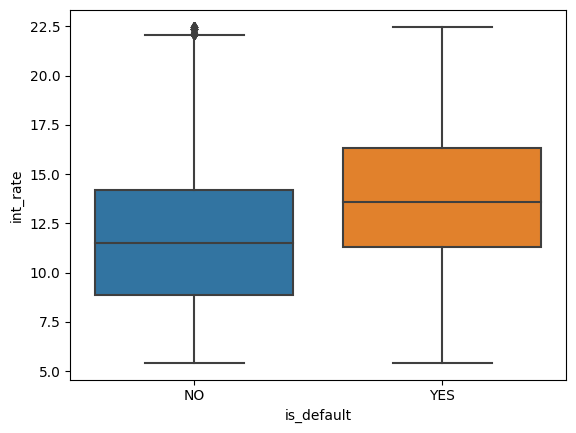

             int_rate                                              
                 mean   min    max <lambda_0> <lambda_1> <lambda_2>
is_default                                                         
NO          11.724186  5.42  24.59       8.88      11.49      14.17
YES         13.820432  5.42  24.40      11.31      13.61      16.40
--------------------------------------------------------------------------------
field =  installment 



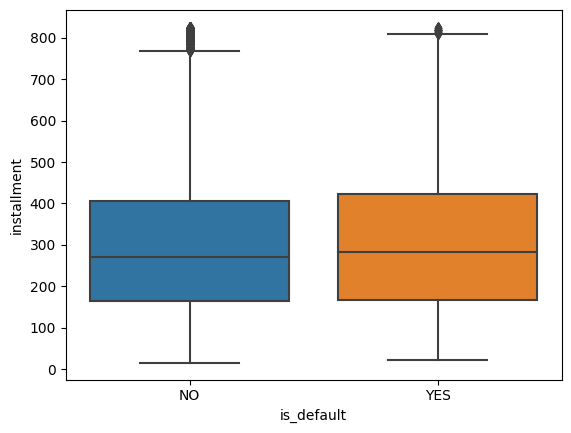

           installment                                                 
                  mean    min      max <lambda_0> <lambda_1> <lambda_2>
is_default                                                             
NO          322.645031  15.69  1295.21    166.310     278.58     426.10
YES         336.175006  22.79  1305.19    168.555     293.87     457.84
--------------------------------------------------------------------------------
field =  annual_inc 



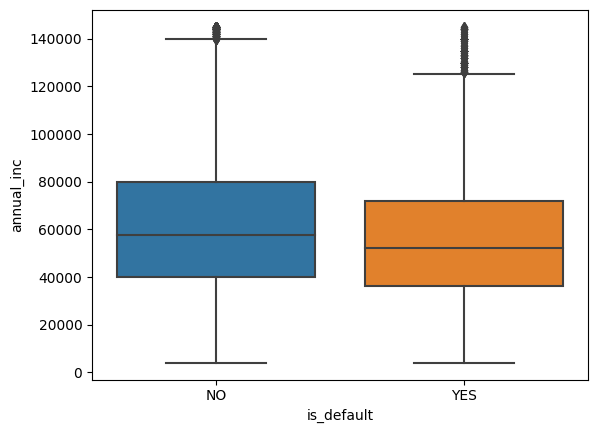

              annual_inc                                                    
                    mean     min        max <lambda_0> <lambda_1> <lambda_2>
is_default                                                                  
NO          70048.707623  4000.0  6000000.0    41830.0    60000.0    84000.0
YES         62427.298034  4080.0  1250000.0    37000.0    53000.0    75000.0
--------------------------------------------------------------------------------
field =  dti 



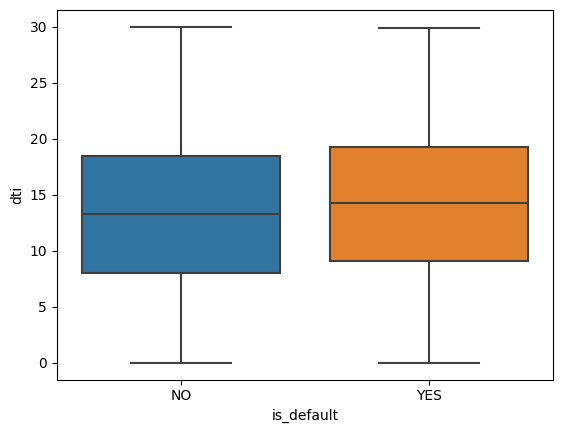

                  dti                                             
                 mean  min    max <lambda_0> <lambda_1> <lambda_2>
is_default                                                        
NO          13.201980  0.0  29.99       8.04      13.25      18.46
YES         14.000624  0.0  29.85       9.05      14.29      19.29
--------------------------------------------------------------------------------
field =  total_rec_prncp 



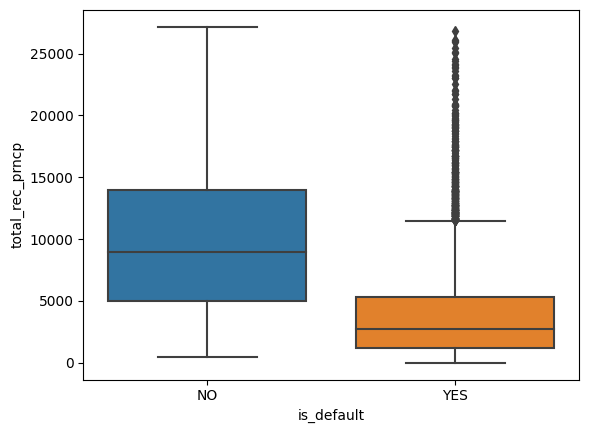

           total_rec_prncp                                                  
                      mean    min       max <lambda_0> <lambda_1> <lambda_2>
is_default                                                                  
NO            10755.034453  500.0  35000.02    5300.00    9600.00   14999.99
YES            3967.177947    0.0  31115.81    1205.78    2729.59    5341.13
--------------------------------------------------------------------------------
field =  revol_bal 



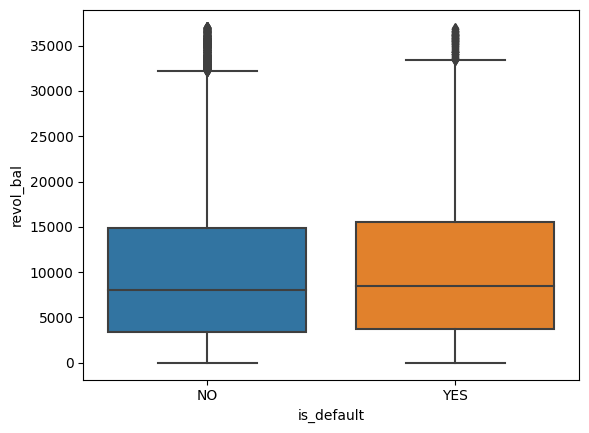

               revol_bal                                             
                    mean min     max <lambda_0> <lambda_1> <lambda_2>
is_default                                                           
NO          13360.786712   0  149588     3656.0     8802.5    16978.0
YES         13514.243647   0  148829     3968.0     9211.0    17518.0
--------------------------------------------------------------------------------
field =  revol_util 



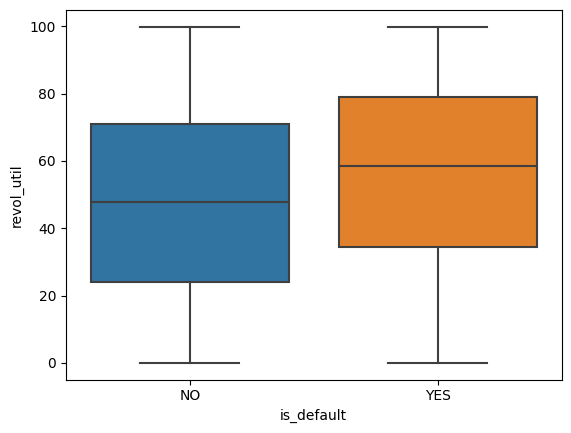

           revol_util                                            
                 mean  min   max <lambda_0> <lambda_1> <lambda_2>
is_default                                                       
NO           47.72169  0.0  99.9       24.1       47.8       71.0
YES          55.57211  0.0  99.9       34.4       58.4       79.0
--------------------------------------------------------------------------------
field =  total_acc 



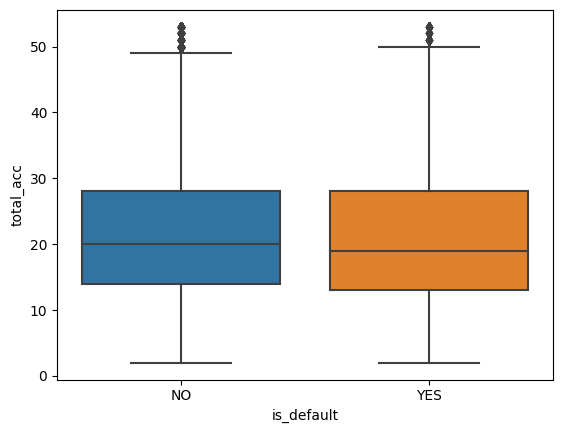

            total_acc                                         
                 mean min max <lambda_0> <lambda_1> <lambda_2>
is_default                                                    
NO          22.197976   2  90       14.0       21.0       29.0
YES         21.427581   2  74       13.0       20.0       28.0
--------------------------------------------------------------------------------
field =  open_acc 



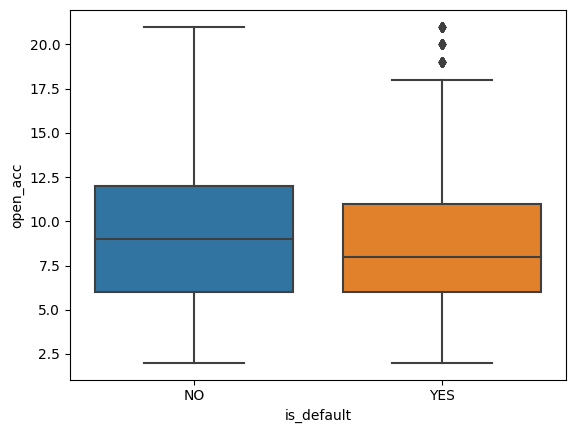

            open_acc                                         
                mean min max <lambda_0> <lambda_1> <lambda_2>
is_default                                                   
NO          9.313611   2  44        6.0        9.0       12.0
YES         9.178070   2  38        6.0        8.0       12.0
--------------------------------------------------------------------------------


In [21]:
def remove_outliers(df: pd.DataFrame, field: str) -> pd.DataFrame:
    Q1 = df[field].quantile(0.25)
    Q3 = df[field].quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    return df[(df[field] >= lower) & (df[field] <= upper)]

for field in quantitative_fields:
    print("field = ", field,'\n')
    clean_df = remove_outliers(df_final, field)
    sns.boxplot(y=field, x='is_default', data=clean_df)
    plt.show()
    df_segment = df_final.groupby('is_default')
    print(df_segment.agg({field : ['mean','min','max', lambda x:x.quantile(0.25), 
                                         lambda x:x.quantile(0.5), lambda x:x.quantile(0.75)]}))
    print("-" * 80)


<span style="color:green">Inferences - Segmented Univariate Analysis:  </span>
- Default loan has higher interest rate than non-default loans. On an average default loan interest rate is 13.88% (2% higher) where as for non default loan interest rate is 11.7%.   

- We can say that defaulter borrowers' annual income is less compared to non-defaulter borrowers'.  

- DTI Ratio = Borrowers monthly debt payment / monthly income
- DTI Ratio is high for defaulers. Borrowers whose monthly debt payment is high compared to monthly income, have less saving. And this will result into loan default.  

- total_rec_prncp - We can clearly see that there is a hugh difference in principal received from defaulters and non-defaulters. Average principal received from non defaulters is around 10.7K where as from non- defaluters is only 4k. Which is almost 60% less principal received from defaulters compared to non-defaulters.   

- revol_util - Revolving line utilization rate is higher for the defaulters than non-defaulters. Loan given to higher amount of credit  borrower is using relative to all available revolving credit leads to loan default.
   
- open_acc - Number of open credit lines in defaulters credit file is less compared to non-defaulters. 

- We see there is much impact of Loan Amount, Funded Amount, Installment on borrowers' default status.

# 5. Bivariate Analysis
---

## A. On Continuous/ Quantitative  Variables

In [22]:
quantitative_fields

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'total_rec_prncp',
 'revol_bal',
 'revol_util',
 'total_acc',
 'open_acc']

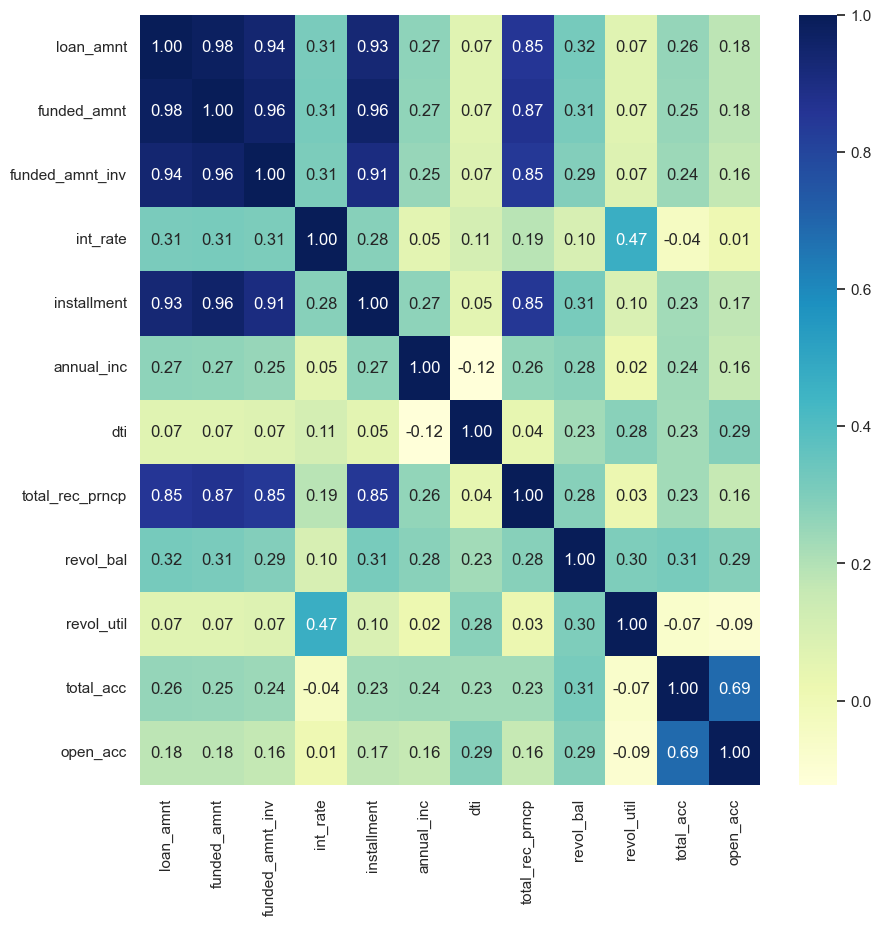

In [23]:
sns.set()
plt.figure(figsize=(10, 10))  # Set the figure size
heatmap = sns.heatmap(df_final[['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'total_rec_prncp',
 'revol_bal',
 'revol_util',
 'total_acc',
 'open_acc']].corr(), fmt='0.2f', cmap="YlGnBu", annot=True)

plt.show()

<span style="color:green">Inferences - Bivariate Analysis on Continuous Variables:  </span>
- loan_amnt, funded_amnt, funded_amnt_inv = We can say there is a very high correlation between loan amount applied by the borrower and loan amount committed by the investor to the borrower. So whenever loan application of the borrower gets passed by company, then he gets almost full amount of the loan applied.
  
- loan_amnt, installment, total_rec_prncp - It is also obvious that monthly installment and loan amount are highly correlated. Higher the loan amount, higher is monthly installment and and higher is principal received  vice versa.
  
- total_acc, open_acc- Number open credit lines is also highly correlated with total number of credit lined in the borrower's credit file.  

- revol_util, int_rate - Revolving line utilization rate and interest rate are moderately correlated with each other. Higher the amount of credit the borrower is using, higher is the risk of loan repayment. Thats why higher is the interest rate, and vice-versa.



## B. On Categorical Variables

In [24]:
object_types_df = load_type_df(df_final, 'object')
categorical_variables = object_types_df[object_types_df["field"] != 'is_default']['field'].to_list()
categorical_variables

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'loan_status',
 'purpose',
 'addr_state']

### We don't need sub_grade, loan_status, addr_state here. So we will exlude these fields


======= Impact of TERM on LOAN STATUS (in percentage) ========



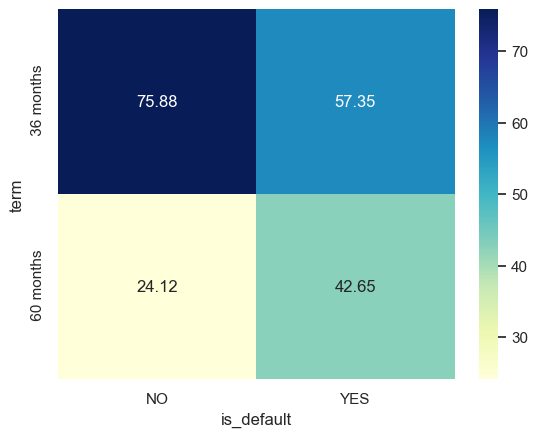


======= Impact of GRADE on LOAN STATUS (in percentage) ========



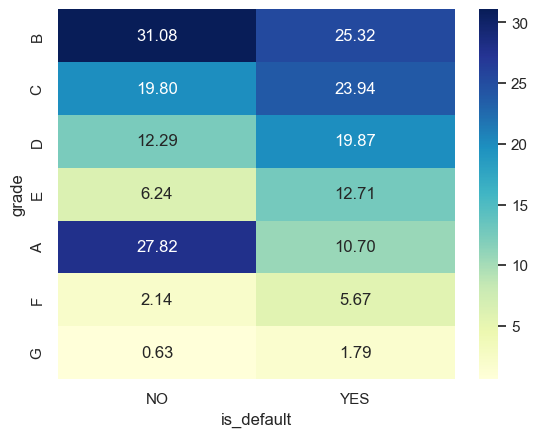


======= Impact of EMP_LENGTH on LOAN STATUS (in percentage) ========



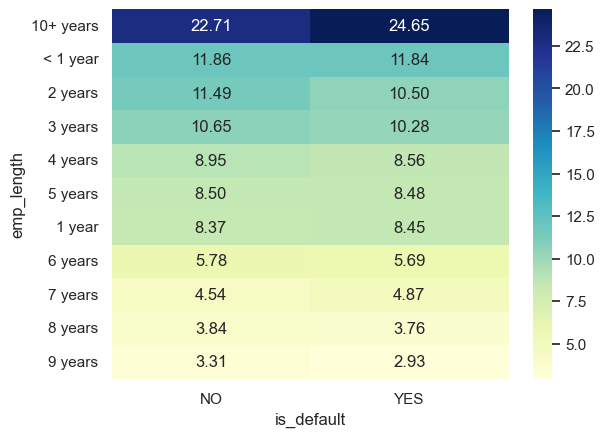


======= Impact of VERIFICATION_STATUS on LOAN STATUS (in percentage) ========



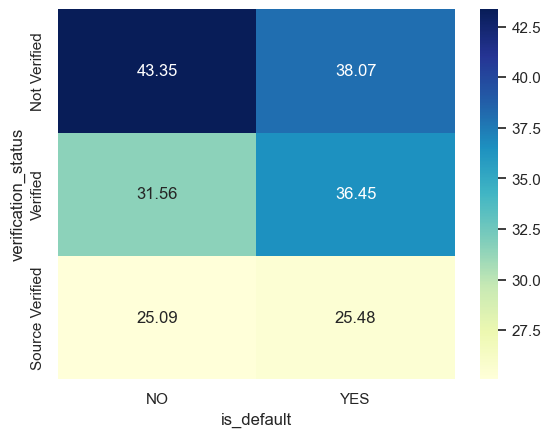


======= Impact of PURPOSE on LOAN STATUS (in percentage) ========



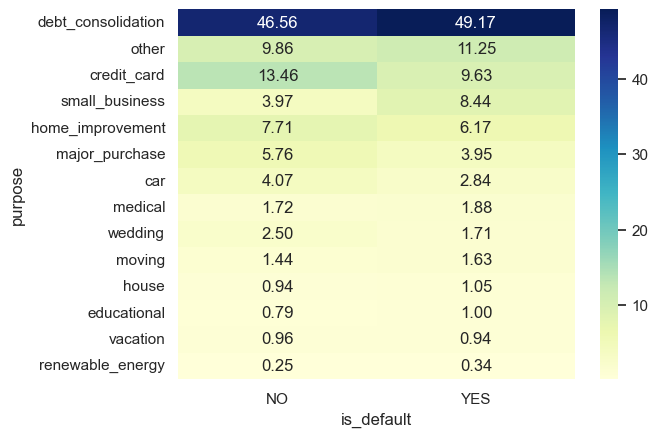

In [25]:
excluded_categorical_fields = ['sub_grade', 'loan_status', 'addr_state']

for f in categorical_variables:

    # Exclude no-need fields
    if f in excluded_categorical_fields:
        continue

    t = pd.pivot_table(
        df_final, 
        index=f, 
        columns='is_default', 
        values='loan_amnt', 
        aggfunc='count',
        ).apply(lambda x: round(x*100/sum(x), 2)).sort_values(by=['YES'], ascending=False)
    
    t.dropna(inplace=True)
    
    if len(t) == 0:
        continue
    
    F = f.upper()
    print(f"\n======= Impact of {F} on LOAN STATUS (in percentage) ========\n")
    
    sns.heatmap(t, cmap='YlGnBu',annot=True, fmt='0.2f')
    plt.show()
    

<span style="color:green">Inferences - Bivariate Analysis on Categorical Variables:  </span>

- TERM: 36 months will be more high-risk then 60 months
- GRADE: B-C-D there percentage of default account high
- PURPOSE: deb_consolidation is high-risk